# Preliminary Data Analysis

**Before:** Some preliminary data analysis on the data acquired during regen testing on July 6th, between 22:02 and 22:04 (PST).
This notebook takes advantage of the custom `TimeSeries` class, which is a data-analysis centric wrapper around `np.ndarray`.

## Purpose of Notebook

The objective of this notebook is to analyze FSGP/ASC 2024 data to quantitatively evaluate how our regenerative braking system performed.

## Creating Client and Imports

In [1]:
from data_tools.collections.time_series import TimeSeries
from data_tools.query.influxdb_query import DBClient
#from simulation.common import BrightSide
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta, timezone
from data_tools.influxdb.fsgp_2024_laps import FSGPDayLaps

mass_Brightside = 350 # kg

# 1st Run
start = "2024-07-16T15:00:00Z"
stop = "2024-07-17T03:00:00Z"
start = datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
stop = datetime.strptime(stop, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)

client = DBClient()

ERROR:data_tools.query.postgresql_query:Could not find a POSTGRESQL_USERNAME in .env!
ERROR:data_tools.query.postgresql_query:Could not find a POSTGRESQL_PASSWORD in .env!
ERROR:data_tools.query.postgresql_query:Could not find a POSTGRESQL_DATABASE in .env!
ERROR:data_tools.query.postgresql_query:Could not find a POSTGRESQL_ADDRESS in .env!


Creating client with API Token: s4Z9_S6_O09kDzYn1KZcs7LVoCA2cVK9_ObY44vR4xMh-wYLSWBkypS0S0ZHQgBvEV2A5LgvQ1IKr8byHes2LA==
Creating client with Org: 8a0b66d77a331e96


## Querying Data and Plotting

Query the data, then align their x–axes such that math is well-defined.

In [2]:
motor_voltage: TimeSeries = client.query_time_series(start, stop, "BatteryVoltage", units="V")
motor_current: TimeSeries = client.query_time_series(start, stop, "BatteryCurrent", units="A")
motor_current_direction: TimeSeries = client.query_time_series(start, stop, "BatteryCurrentDirection", units="")
vehicle_velocity: TimeSeries = client.query_time_series(start, stop, "VehicleVelocity", units="m/s")
motor_current, motor_voltage, vehicle_velocity, motor_current_direction = TimeSeries.align(motor_current, motor_voltage, vehicle_velocity, motor_current_direction)
motor_current_signed = motor_current.promote(np.fromiter(map(lambda x: -x[1] if motor_current_direction[x[0]] == 1 else x[1], enumerate(motor_current)), dtype=float))

Plot the data to make sure nothing bad or spooky happened (and matches what's seen on InfluxDB Data Explorer).

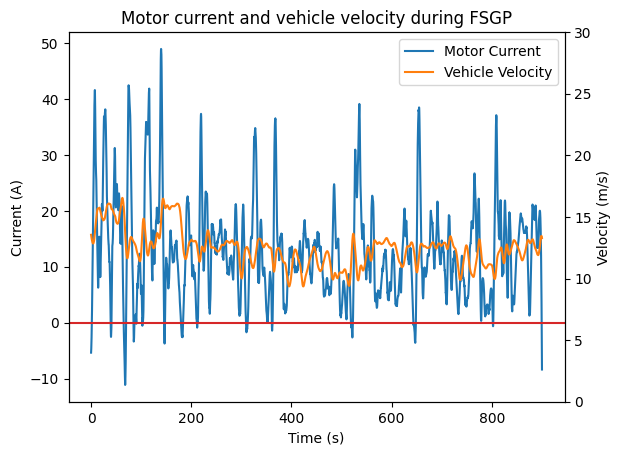

In [3]:
from scipy import signal
fig, ax = plt.subplots()
ax2 = ax.twinx()

good_motor_current = motor_current_signed.promote(signal.savgol_filter(motor_current_signed[600.:1500.], 100, 3))
good_vehicle_velocity = vehicle_velocity.promote(signal.savgol_filter(vehicle_velocity[600.:1500.], 100, 3))

lns1 = ax.plot(good_motor_current.x_axis, good_motor_current, label="Motor Current", color="tab:blue")
ax.set_xlabel("Time (s)")
ax.set_title("Motor current and vehicle velocity during FSGP")
ax.set_ylabel("Current (A)")
lns2 = ax2.plot(good_vehicle_velocity.x_axis, good_vehicle_velocity, label="Vehicle Velocity", color="tab:orange")
ax2.set_ylim(0, 30)
ax.axhline(0, color="tab:red")
ax2.set_ylabel("Velocity (m/s)")
# added these three lines
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs)
plt.show()

## Finding Regen

Now, let's find the time that current is negative (regen is occurring). We do this by finding the indices where regen occurs.

In [4]:
# Find indices where regen occurs
current_negative_mask = np.where(motor_current_signed < 0)[0]

# Group consecutive indices to identify regen periods
regen_periods = []
current_period = [current_negative_mask[0]] # Start the first regen period with the first negative current index

for i in range(1, len(current_negative_mask)):
    # If indices are consecutive, extend the current_period
    if current_negative_mask[i] == current_negative_mask[i - 1] + 1:
        current_period.append(current_negative_mask[i]) 
    # If indices are not consecutive, add the list of current_period to regen_periods
    else:
        regen_periods.append(current_period) 
        current_period = [current_negative_mask[i]] # Start a new current_period with index i

regen_periods.append(current_period)  # Add the last current_period to the list of regen periods 

for period in regen_periods:
    # We find the indices, as slicing pack_current with current_negative_mask isn't a well-defined operation
    first_regen_index = period[0]
    last_regen_index = period[-1]

    regen_current = motor_current_signed[first_regen_index:last_regen_index]
    regen_voltage = motor_voltage[first_regen_index:last_regen_index]

In [5]:
# regen_periods

We can also inspect the change in velocity to get a sense of the change in kinetic energy, estimating a vehicle mass of 300kg.

In [6]:
period_index = 1 # Keep track of index while printing velocities, energies and efficiencies

for period in regen_periods:
    initial_velocity = vehicle_velocity[period[0]]                              # Units: m/s
    final_velocity = vehicle_velocity[period[-1]]                                 # Units: m/s
    kinetic_energy  = lambda vi, vf: 0.5 * mass_Brightside * (vf**2 - vi**2)    # Units: J
    delta_kinetic_energy = -kinetic_energy(final_velocity, initial_velocity)            # Units: J

    # print(f"Initial Velocity for Period {period_index}: {initial_velocity:.4f} {vehicle_velocity.units}")
    # print(f"Final Velocity for Period {period_index}: {final_velocity:.4f} {vehicle_velocity.units}")
    # print(f"Change in Kinetic Energy for Period {period_index}: {delta_kinetic_energy:.4f} J")

    period_index += 1

Now, let's calculate the battery power during regen.
Note: the elementwise-array multiplication returns an `ndarray`, so I use `regen_current.promote()` on the result to get back a `TimeSeries`.

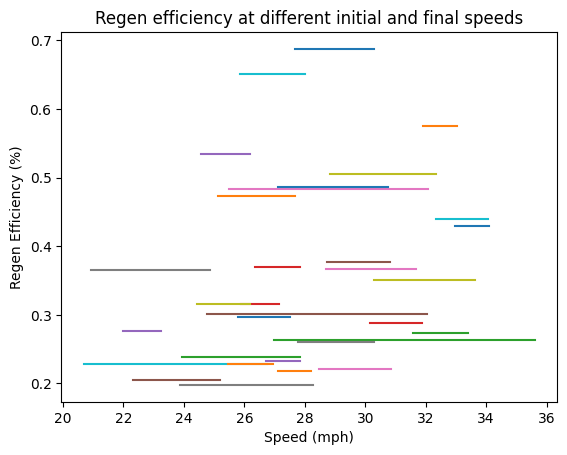

In [7]:
period_index = 1 # Keep track of index while printing velocities, energies and efficiencies

fig, ax = plt.subplots()

for period in regen_periods:
    if len(period) < 10:
        period_index += 1
        continue

    first_regen_index = period[0]
    last_regen_index = period[-1]

    initial_velocity = vehicle_velocity[period[0]]                              # Units: m/s
    final_velocity = vehicle_velocity[period[-1]]                                 # Units: m/s

    if (abs(final_velocity - initial_velocity) < 0.5) or (final_velocity > initial_velocity):
        period_index += 1
        continue

    kinetic_energy  = lambda vi, vf: 0.5 * mass_Brightside * (vf**2 - vi**2)    # Units: J
    delta_kinetic_energy = -kinetic_energy(final_velocity, initial_velocity)            # Units: J

    regen_current = motor_current_signed[first_regen_index:last_regen_index]
    regen_voltage = motor_voltage[first_regen_index:last_regen_index]

    regen_power = regen_current.promote(regen_current * regen_voltage)
    regen_power.units = "W"  # Fix units after math
    regen_power.meta["field"] = "Pack Power"

    regen_energy = np.trapezoid(regen_power, regen_power.x_axis)  # Units: J
    efficiency: float = regen_energy / delta_kinetic_energy

    if efficiency > 1:
        period_index += 1
        continue

    period_index += 1
    ax.plot([final_velocity * 3.6 / 1.609, initial_velocity * 3.6 / 1.609], [efficiency, efficiency])

ax.set_xlabel("Speed (mph)")
ax.set_ylabel("Regen Efficiency (%)")
ax.set_title("Regen efficiency at different initial and final speeds")

plt.show()

Now, let's integrate with respect to time to get regen energy, and then get efficiency.

# FSGP Day 1 Regen Analysis

## Setting Constants

In [8]:
# Setting FSGP Day
day_num = 1
day = FSGPDayLaps(day_num)
total_laps = day.get_lap_count()

start = day.get_start_utc(1)
stop = day.get_finish_utc(total_laps)
start = datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
stop = datetime.strptime(stop, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)


## Querying Data and Plotting

In [9]:
motor_voltage: TimeSeries = client.query_time_series(start, stop, "BatteryVoltage", units="V")
motor_current: TimeSeries = client.query_time_series(start, stop, "BatteryCurrent", units="A")
motor_current_direction: TimeSeries = client.query_time_series(start, stop, "BatteryCurrentDirection", units="")
vehicle_velocity_day1: TimeSeries = client.query_time_series(start, stop, "VehicleVelocity", units="m/s")
motor_current, motor_voltage, vehicle_velocity_day1, motor_current_direction = TimeSeries.align(motor_current, motor_voltage, vehicle_velocity_day1, motor_current_direction)
motor_current_signed = motor_current.promote(np.fromiter(map(lambda x: -x[1] if motor_current_direction[x[0]] == 1 else x[1], enumerate(motor_current)), dtype=float))

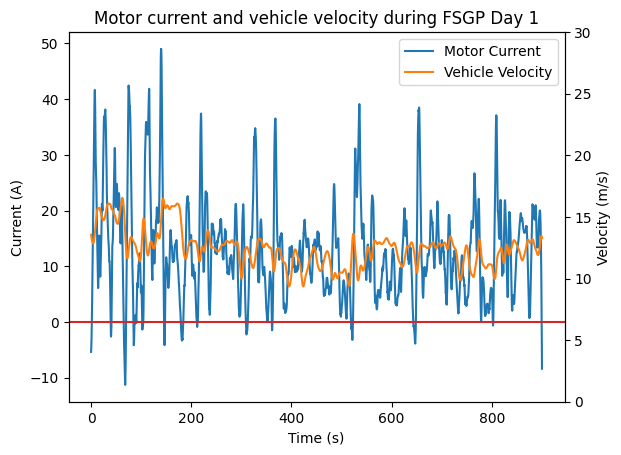

In [10]:
from scipy import signal
fig, ax = plt.subplots()
ax2 = ax.twinx()

good_motor_current = motor_current_signed.promote(signal.savgol_filter(motor_current_signed[600.:1500.], 100, 3))
good_vehicle_velocity_day1 = vehicle_velocity_day1.promote(signal.savgol_filter(vehicle_velocity_day1[600.:1500.], 100, 3))

lns1 = ax.plot(good_motor_current.x_axis, good_motor_current, label="Motor Current", color="tab:blue")
ax.set_xlabel("Time (s)")
ax.set_title("Motor current and vehicle velocity during FSGP Day 1")
ax.set_ylabel("Current (A)")
lns2 = ax2.plot(good_vehicle_velocity_day1.x_axis, good_vehicle_velocity_day1, label="Vehicle Velocity", color="tab:orange")
ax2.set_ylim(0, 30)
ax.axhline(0, color="tab:red")
ax2.set_ylabel("Velocity (m/s)")
# added these three lines
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs)
plt.show()

## Finding Regen

In [11]:
# Find indices where regen occurs
current_negative_mask = np.where(motor_current_signed < 0)[0]

# Group consecutive indices to identify regen periods
regen_periods = []
current_period = [current_negative_mask[0]] # Start the first regen period with the first negative current index

for i in range(1, len(current_negative_mask)):
    # If indices are consecutive, extend the current_period
    if current_negative_mask[i] == current_negative_mask[i - 1] + 1:
        current_period.append(current_negative_mask[i]) 
    # If indices are not consecutive, add the list of current_period to regen_periods
    else:
        regen_periods.append(current_period) 
        current_period = [current_negative_mask[i]] # Start a new current_period with index i

regen_periods.append(current_period)  # Add the last current_period to the list of regen periods 

for period in regen_periods:
    # We find the indices, as slicing pack_current with current_negative_mask isn't a well-defined operation
    first_regen_index = period[0]
    last_regen_index = period[-1]

    regen_current = motor_current_signed[first_regen_index:last_regen_index]
    regen_voltage = motor_voltage[first_regen_index:last_regen_index]

In [12]:
# REGEN CURRENTS FOR THE DAY
regen_currents_day1= []
for index in current_negative_mask:
    regen_currents_day1.append(motor_current_signed[index])

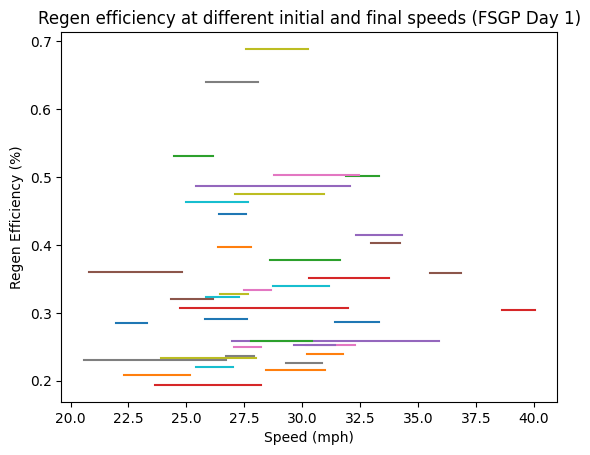

In [13]:
period_index = 1 # Keep track of index while printing velocities, energies and efficiencies

fig, ax = plt.subplots()

velocities_day1 = []  # mph
efficiencies_day1 = []  # %

for period in regen_periods:
    if len(period) < 10:
        period_index += 1
        continue

    first_regen_index = period[0]
    last_regen_index = period[-1]

    initial_velocity = vehicle_velocity_day1[period[0]]                              # Units: m/s
    final_velocity = vehicle_velocity_day1[period[-1]]                                 # Units: m/s

    if (abs(final_velocity - initial_velocity) < 0.5) or (final_velocity > initial_velocity):
        period_index += 1
        continue

    kinetic_energy  = lambda vi, vf: 0.5 * mass_Brightside * (vf**2 - vi**2)    # Units: J
    delta_kinetic_energy = -kinetic_energy(final_velocity, initial_velocity)            # Units: J

    regen_current = motor_current_signed[first_regen_index:last_regen_index]
    regen_voltage = motor_voltage[first_regen_index:last_regen_index]

    regen_power = regen_current.promote(regen_current * regen_voltage)
    regen_power.units = "W"  # Fix units after math
    regen_power.meta["field"] = "Pack Power"

    regen_energy = np.trapezoid(regen_power, regen_power.x_axis)  # Units: J
    efficiency: float = regen_energy / delta_kinetic_energy

    if efficiency > 1:
        period_index += 1
        continue

    velocities_day1.append(initial_velocity  * (3.6 / 1.609))
    efficiencies_day1.append(efficiency)

    period_index += 1
    
    ax.plot([final_velocity * 3.6 / 1.609, initial_velocity * 3.6 / 1.609], [efficiency, efficiency])

ax.set_xlabel("Speed (mph)")
ax.set_ylabel("Regen Efficiency (%)")
ax.set_title("Regen efficiency at different initial and final speeds (FSGP Day 1)")

plt.show()

## Observations

First of all, it seems that we do not get any regen for initial speeds below 22.5 mph (10.06 m/s) and speeds above 40 mph (17.9 m/s). I can also observe that there seems to a range where regen efficiency is maximized. This happens whenever we drive between 27.5 - 32.5 mph (12.3 - 14.5 m/s). If we focus on times when we got regen above 45%, we see that it only happens between 26 - 34 mph. However, it is important to note there are still cases when our initial starting speed falls within that range, yet our regen efficiency is below 45%.

## When do we get Regen?

I want to get a better idea of the conditions that need to be satisfied for us to get regen. I will be looking at the role played by the speed of the car.

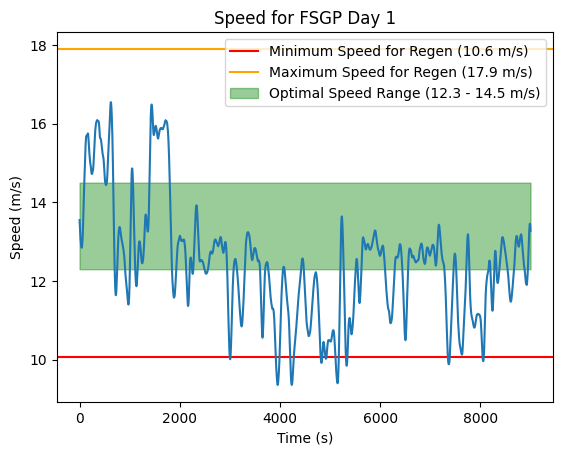

In [17]:
plt.title("Speed for FSGP Day 1")
plt.xlabel("Time (s)")
plt.ylabel("Speed (m/s)")
plt.axhline(y=10.06, c = "red", label = "Minimum Speed for Regen (10.6 m/s)")
plt.axhline(y=17.9, c = "orange", label = "Maximum Speed for Regen (17.9 m/s)")
plt.fill_between(range(len(good_vehicle_velocity_day1)),12.3, 14.5, color='green', alpha=0.4, label="Optimal Speed Range (12.3 - 14.5 m/s)")
plt.legend()
plt.plot(good_vehicle_velocity_day1)

In [18]:
#regen_periods

## How much time in each Region?

In [19]:
time_above_min = len(np.where(vehicle_velocity_day1 > 10.6)[0])
time_below_max = len(np.where(vehicle_velocity_day1 < 17.9)[0])
time_optimal = len(np.where((12.3 < vehicle_velocity_day1) & (vehicle_velocity_day1 < 14.5))[0])
total_time = len(vehicle_velocity_day1)

print(f"The time above minimum speed was {time_above_min} s or a proportion of {time_above_min/total_time:.2f}")
print(f"The time below maximum speed was {time_below_max} s or a proportion of {time_below_max/total_time:.2f}")
print(f"The time within optimal speed range was {time_optimal} s or a proportion of {time_optimal/total_time:.2f}")
print(f"Total time was {total_time} s")

The time above minimum speed was 159078 s or a proportion of 0.78
The time below maximum speed was 203575 s or a proportion of 1.00
The time within optimal speed range was 76528 s or a proportion of 0.38
Total time was 203797 s


# FSGP Day 3 Regen Analysis

## Setting Constants

In [20]:
# Setting FSGP Day
day_num = 3
day = FSGPDayLaps(day_num)
total_laps = day.get_lap_count()

start = day.get_start_utc(1)
stop = day.get_finish_utc(total_laps)
start = datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
stop = datetime.strptime(stop, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)

## Querying Data and Plotting

In [21]:
motor_voltage: TimeSeries = client.query_time_series(start, stop, "BatteryVoltage", units="V")
motor_current: TimeSeries = client.query_time_series(start, stop, "BatteryCurrent", units="A")
motor_current_direction: TimeSeries = client.query_time_series(start, stop, "BatteryCurrentDirection", units="")
vehicle_velocity_day3: TimeSeries = client.query_time_series(start, stop, "VehicleVelocity", units="m/s")
motor_current, motor_voltage, vehicle_velocity_day3, motor_current_direction = TimeSeries.align(motor_current, motor_voltage, vehicle_velocity_day3, motor_current_direction)
motor_current_signed = motor_current.promote(np.fromiter(map(lambda x: -x[1] if motor_current_direction[x[0]] == 1 else x[1], enumerate(motor_current)), dtype=float))

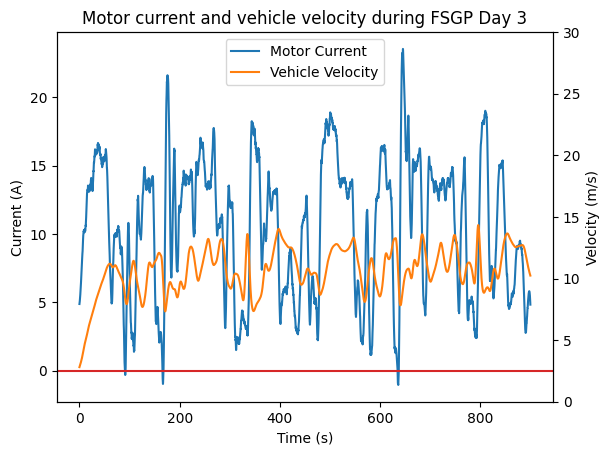

In [22]:
from scipy import signal
fig, ax = plt.subplots()
ax2 = ax.twinx()

good_motor_current = motor_current_signed.promote(signal.savgol_filter(motor_current_signed[600.:1500.], 100, 3))
good_vehicle_velocity_day3 = vehicle_velocity_day3.promote(signal.savgol_filter(vehicle_velocity_day3[600.:1500.], 100, 3))

lns1 = ax.plot(good_motor_current.x_axis, good_motor_current, label="Motor Current", color="tab:blue")
ax.set_xlabel("Time (s)")
ax.set_title("Motor current and vehicle velocity during FSGP Day 3")
ax.set_ylabel("Current (A)")
lns2 = ax2.plot(good_vehicle_velocity_day3.x_axis, good_vehicle_velocity_day3, label="Vehicle Velocity", color="tab:orange")
ax2.set_ylim(0, 30)
ax.axhline(0, color="tab:red")
ax2.set_ylabel("Velocity (m/s)")
# added these three lines
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs)
plt.show()

## Finding Regen

In [23]:
# Find indices where regen occurs
current_negative_mask = np.where(motor_current_signed < 0)[0]

# Group consecutive indices to identify regen periods
regen_periods = []
current_period = [current_negative_mask[0]] # Start the first regen period with the first negative current index

for i in range(1, len(current_negative_mask)):
    # If indices are consecutive, extend the current_period
    if current_negative_mask[i] == current_negative_mask[i - 1] + 1:
        current_period.append(current_negative_mask[i]) 
    # If indices are not consecutive, add the list of current_period to regen_periods
    else:
        regen_periods.append(current_period) 
        current_period = [current_negative_mask[i]] # Start a new current_period with index i

regen_periods.append(current_period)  # Add the last current_period to the list of regen periods 

for period in regen_periods:
    # We find the indices, as slicing pack_current with current_negative_mask isn't a well-defined operation
    first_regen_index = period[0]
    last_regen_index = period[-1]

    regen_current = motor_current_signed[first_regen_index:last_regen_index]
    regen_voltage = motor_voltage[first_regen_index:last_regen_index]

In [24]:
# REGEN CURRENTS FOR THE DAY
regen_currents_day3= []
for index in current_negative_mask:
    regen_currents_day3.append(motor_current_signed[index])

In [25]:
#regen_periods

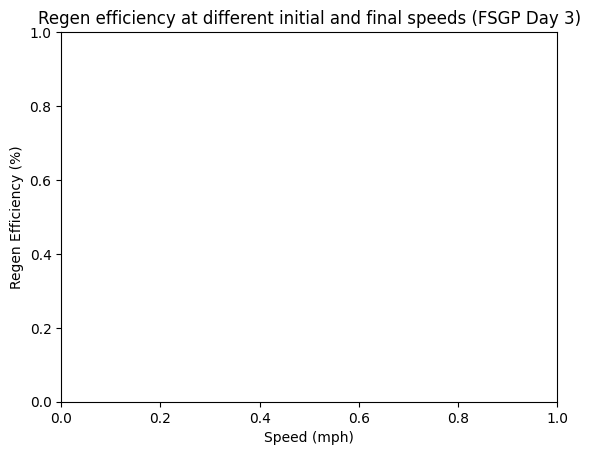

12.979134372699296


In [26]:
period_index = 1 # Keep track of index while printing velocities, energies and efficiencies

fig, ax = plt.subplots()

velocities_day3 = []
efficiencies_day3 = []

for period in regen_periods:
    if len(period) < 10:
        period_index += 1
        continue

    first_regen_index = period[0]
    last_regen_index = period[-1]

    initial_velocity = vehicle_velocity_day3[period[0]]                              # Units: m/s
    final_velocity = vehicle_velocity_day3[period[-1]]                                 # Units: m/s

    if (abs(final_velocity - initial_velocity) < 0.5) or (final_velocity > initial_velocity):
        period_index += 1
        continue

    kinetic_energy  = lambda vi, vf: 0.5 * mass_Brightside * (vf**2 - vi**2)    # Units: J
    delta_kinetic_energy = -kinetic_energy(final_velocity, initial_velocity)            # Units: J

    regen_current = motor_current_signed[first_regen_index:last_regen_index]
    regen_voltage = motor_voltage[first_regen_index:last_regen_index]

    regen_power = regen_current.promote(regen_current * regen_voltage)
    regen_power.units = "W"  # Fix units after math
    regen_power.meta["field"] = "Pack Power"

    regen_energy = np.trapezoid(regen_power, regen_power.x_axis)  # Units: J
    efficiency: float = regen_energy / delta_kinetic_energy

    if efficiency > 1:
        period_index += 1
        continue

    velocities_day3.append(initial_velocity  * (3.6 / 1.609))
    efficiencies_day3.append(efficiency)

    period_index += 1
    ax.plot([final_velocity * 3.6 / 1.609, initial_velocity * 3.6 / 1.609], [efficiency, efficiency])

ax.set_xlabel("Speed (mph)")
ax.set_ylabel("Regen Efficiency (%)")
ax.set_title("Regen efficiency at different initial and final speeds (FSGP Day 3)")

plt.show()

print(final_velocity)

## When do we get Regen?

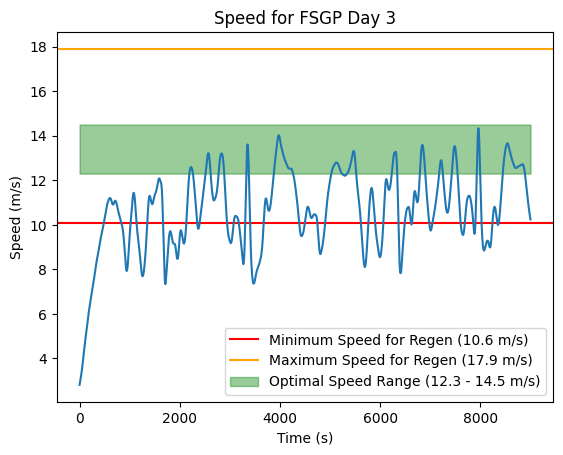

In [27]:
plt.title("Speed for FSGP Day 3")
plt.xlabel("Time (s)")
plt.ylabel("Speed (m/s)")
plt.axhline(y=10.06, c = "red", label = "Minimum Speed for Regen (10.6 m/s)")
plt.axhline(y=17.9, c = "orange", label = "Maximum Speed for Regen (17.9 m/s)")
plt.fill_between(range(len(good_vehicle_velocity_day3)),12.3, 14.5, color='green', alpha=0.4, label="Optimal Speed Range (12.3 - 14.5 m/s)")
plt.legend()
plt.plot(good_vehicle_velocity_day3)

## How much time in each Region?

In [28]:
time_above_min = len(np.where(vehicle_velocity_day3 > 10.6)[0])
time_below_max = len(np.where(vehicle_velocity_day3 < 17.9)[0])
time_optimal = len(np.where((12.3 < vehicle_velocity_day3) & (vehicle_velocity_day3 < 14.5))[0])
total_time = len(vehicle_velocity_day3)

print(f"The time above minimum speed was {time_above_min} s or a proportion of {time_above_min/total_time:.2f}")
print(f"The time below maximum speed was {time_below_max} s or a proportion of {time_below_max/total_time:.2f}")
print(f"The time within optimal speed range was {time_optimal} s or a proportion of {time_optimal/total_time:.2f}")
print(f"Total time was {total_time} s")

The time above minimum speed was 113633 s or a proportion of 0.41
The time below maximum speed was 275638 s or a proportion of 1.00
The time within optimal speed range was 48079 s or a proportion of 0.17
Total time was 275638 s


# ASC Day 1 Regen Analysis

ASC started on July 20. According to the data on Influx, it seems like we started racing at around 10 AM, Kentucky time, which is equivalent to 3PM UTC. It also seems like the end time was 10 PM UTC.

## Setting Constants

In [29]:
start = "2024-07-20T15:00:00Z"
stop = "2024-07-20T22:00:00Z"
start = datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
stop = datetime.strptime(stop, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)

## Querying Data and Plotting

In [31]:
motor_voltage: TimeSeries = client.query_time_series(start, stop, "BatteryVoltage", units="V")
motor_current: TimeSeries = client.query_time_series(start, stop, "BatteryCurrent", units="A")
motor_current_direction: TimeSeries = client.query_time_series(start, stop, "BatteryCurrentDirection", units="")
vehicle_velocity: TimeSeries = client.query_time_series(start, stop, "VehicleVelocity", units="m/s")
motor_current, motor_voltage, vehicle_velocity, motor_current_direction = TimeSeries.align(motor_current, motor_voltage, vehicle_velocity, motor_current_direction)
motor_current_signed = motor_current.promote(np.fromiter(map(lambda x: -x[1] if motor_current_direction[x[0]] == 1 else x[1], enumerate(motor_current)), dtype=float))

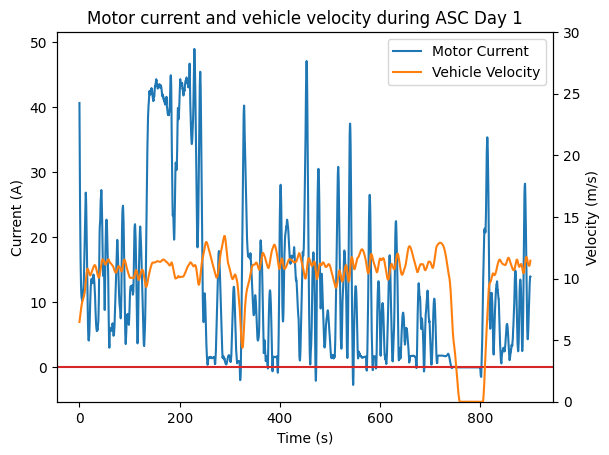

In [32]:
from scipy import signal
fig, ax = plt.subplots()
ax2 = ax.twinx()

good_motor_current = motor_current_signed.promote(signal.savgol_filter(motor_current_signed[600.:1500.], 100, 3))
good_vehicle_velocity = vehicle_velocity.promote(signal.savgol_filter(vehicle_velocity[600.:1500.], 100, 3))

lns1 = ax.plot(good_motor_current.x_axis, good_motor_current, label="Motor Current", color="tab:blue")
ax.set_xlabel("Time (s)")
ax.set_title("Motor current and vehicle velocity during ASC Day 1")
ax.set_ylabel("Current (A)")
lns2 = ax2.plot(good_vehicle_velocity.x_axis, good_vehicle_velocity, label="Vehicle Velocity", color="tab:orange")
ax2.set_ylim(0, 30)
ax.axhline(0, color="tab:red")
ax2.set_ylabel("Velocity (m/s)")
# added these three lines
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs)
plt.show()

## Finding Regen

In [33]:
# Find indices where regen occurs
current_negative_mask = np.where(motor_current_signed < 0)[0]

# Group consecutive indices to identify regen periods
regen_periods = []
current_period = [current_negative_mask[0]] # Start the first regen period with the first negative current index

for i in range(1, len(current_negative_mask)):
    # If indices are consecutive, extend the current_period
    if current_negative_mask[i] == current_negative_mask[i - 1] + 1:
        current_period.append(current_negative_mask[i]) 
    # If indices are not consecutive, add the list of current_period to regen_periods
    else:
        regen_periods.append(current_period) 
        current_period = [current_negative_mask[i]] # Start a new current_period with index i

regen_periods.append(current_period)  # Add the last current_period to the list of regen periods 

for period in regen_periods:
    # We find the indices, as slicing pack_current with current_negative_mask isn't a well-defined operation
    first_regen_index = period[0]
    last_regen_index = period[-1]

    regen_current = motor_current_signed[first_regen_index:last_regen_index]
    regen_voltage = motor_voltage[first_regen_index:last_regen_index]

In [34]:
# REGEN CURRENTS FOR THE DAY
regen_currents_asc= []
for index in current_negative_mask:
    regen_currents_asc.append(motor_current_signed[index])

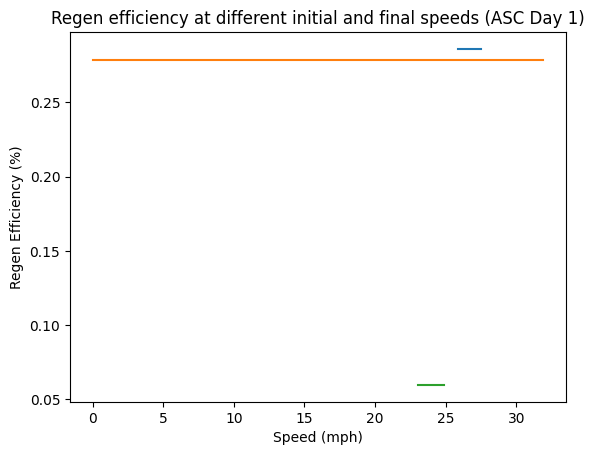

In [35]:
period_index = 1 # Keep track of index while printing velocities, energies and efficiencies

fig, ax = plt.subplots()

velocities_asc = []
efficiencies_asc = []

for period in regen_periods:
    if len(period) < 10:
        period_index += 1
        continue

    first_regen_index = period[0]
    last_regen_index = period[-1]

    initial_velocity = vehicle_velocity[period[0]]                              # Units: m/s
    final_velocity = vehicle_velocity[period[-1]]                                 # Units: m/s

    if (abs(final_velocity - initial_velocity) < 0.5) or (final_velocity > initial_velocity):
        period_index += 1
        continue

    kinetic_energy  = lambda vi, vf: 0.5 * mass_Brightside * (vf**2 - vi**2)    # Units: J
    delta_kinetic_energy = -kinetic_energy(final_velocity, initial_velocity)            # Units: J

    regen_current = motor_current_signed[first_regen_index:last_regen_index]
    regen_voltage = motor_voltage[first_regen_index:last_regen_index]

    regen_power = regen_current.promote(regen_current * regen_voltage)
    regen_power.units = "W"  # Fix units after math
    regen_power.meta["field"] = "Pack Power"

    regen_energy = np.trapezoid(regen_power, regen_power.x_axis)  # Units: J
    efficiency: float = regen_energy / delta_kinetic_energy

    if efficiency > 1:
        period_index += 1
        continue

    velocities_asc.append(initial_velocity  * (3.6 / 1.609))
    efficiencies_asc.append(efficiency)

    period_index += 1
    ax.plot([final_velocity * 3.6 / 1.609, initial_velocity * 3.6 / 1.609], [efficiency, efficiency])

ax.set_xlabel("Speed (mph)")
ax.set_ylabel("Regen Efficiency (%)")
ax.set_title("Regen efficiency at different initial and final speeds (ASC Day 1)")

plt.show()

## When do we get Regen?

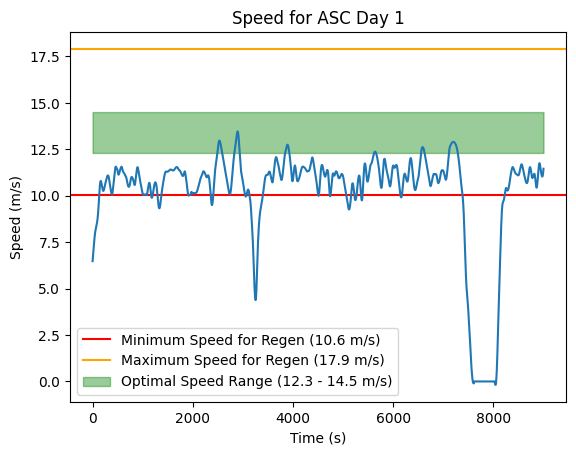

In [36]:
plt.title("Speed for ASC Day 1")
plt.xlabel("Time (s)")
plt.ylabel("Speed (m/s)")
plt.axhline(y=10.06, c = "red", label = "Minimum Speed for Regen (10.6 m/s)")
plt.axhline(y=17.9, c = "orange", label = "Maximum Speed for Regen (17.9 m/s)")
plt.fill_between(range(len(good_vehicle_velocity)),12.3, 14.5, color='green', alpha=0.4, label="Optimal Speed Range (12.3 - 14.5 m/s)")
plt.legend()
plt.plot(good_vehicle_velocity)

## How much time in each Region?

In [37]:
time_above_min = len(np.where(vehicle_velocity > 10.6)[0])
time_below_max = len(np.where(vehicle_velocity < 17.9)[0])
time_optimal = len(np.where((12.3 < vehicle_velocity) & (vehicle_velocity < 14.5))[0])
total_time = len(vehicle_velocity)

print(f"The time above minimum speed was {time_above_min} s or a proportion of {time_above_min/total_time:.2f}")
print(f"The time below maximum speed was {time_below_max} s or a proportion of {time_below_max/total_time:.2f}")
print(f"The time within optimal speed range was {time_optimal} s or a proportion of {time_optimal/total_time:.2f}")
print(f"Total time was {total_time} s")

The time above minimum speed was 132405 s or a proportion of 0.62
The time below maximum speed was 192155 s or a proportion of 0.90
The time within optimal speed range was 23523 s or a proportion of 0.11
Total time was 214300 s


# Some Thoughts

FSGP Day 1 is the day where we spent the most time within the optimal speed range as well as the day where we spent the most time above the minimum speed threshold. As a result, it makes sense that it is also the day where we got the most regen. However, I do think that there are be other factors at play.

# Finding Max and Avg Regen Current

I proceed to find the maximum and average regen current whenever we actually get regen current. 

In [38]:
import statistics

all_regen_currents = regen_currents_asc + regen_currents_day1 + regen_currents_day3

average_regen_currents = statistics.mean(all_regen_currents)

print(f"The average regen current is {average_regen_currents:.2f} A")
print(f"The maximum regen current we get is {min(all_regen_currents):.2f} A")

The average regen current is -5.80 A
The maximum regen current we get is -11.00 A


# Regen Efficiency Function

I want to define a function that tells me regen efficiency as a function of initial vehicle velocity. This will allow me to implement better regen constraints in Simulation. I started by finding all of the initial velocities that started our regen periods across all days.

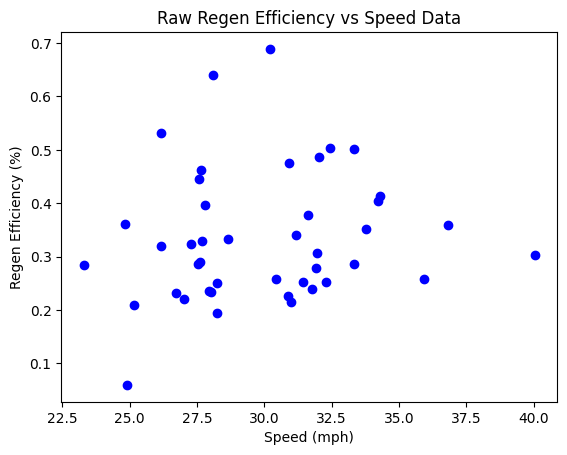

In [49]:
# Plotting Data Points

all_velocities = velocities_day1 + velocities_day3 + velocities_asc 
all_efficiencies = efficiencies_day1 + efficiencies_day3 + efficiencies_asc

plt.scatter(all_velocities, all_efficiencies, color = "blue", marker = "o")
plt.title("Raw Regen Efficiency vs Speed Data")
plt.xlabel("Speed (mph)")
plt.ylabel("Regen Efficiency (%)")
plt.show()

In [77]:
# Removing 3 most efficient points; outliers
highest_efficiency_indices = np.argsort(all_efficiencies)[-3:]
filtered_efficiencies = np.delete(all_efficiencies, highest_efficiency_indices)
filtered_velocities = np.delete(all_velocities, highest_efficiency_indices)
filtered_efficiencies = np.delete(filtered_efficiencies, np.where(filtered_velocities > 35))
filtered_velocities = np.delete(filtered_velocities, np.where(filtered_velocities > 35))
filtered_velocities = np.delete(filtered_velocities, np.where(filtered_efficiencies < 0.1))
filtered_efficiencies = np.delete(filtered_efficiencies, np.where(filtered_efficiencies < 0.1))

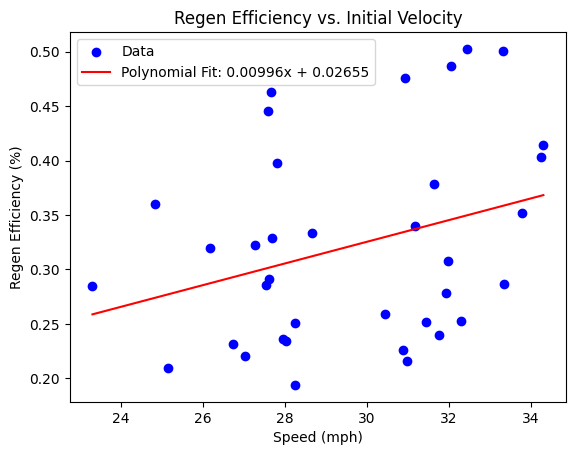

In [86]:
# Perform polynomial fit (degree 2)
coeffs = np.polyfit(filtered_velocities, filtered_efficiencies, deg=1)
poly_func = np.poly1d(coeffs)

# Generate smooth velocity range for plotting
vel_range = np.linspace(min(filtered_velocities), max(filtered_velocities), 100)
fit_efficiencies = poly_func(vel_range)

# Plot scatter and fitted curve
plt.scatter(filtered_velocities, filtered_efficiencies, color="blue", marker="o", label="Data")
plt.plot(vel_range, fit_efficiencies, color="red", label=f"Polynomial Fit: {coeffs[0]:.5f}x + {coeffs[1]:.5f}")
plt.xlabel("Speed (mph)")
plt.ylabel("Regen Efficiency (%)")
plt.title("Regen Efficiency vs. Initial Velocity")
plt.legend()
plt.show()